# Model Notebook

In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        
print("Imported the dataset")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This is the notebook for model in the Age and Gender Detector.Here we will extract the data, train it and fit it into our model, evaluate our results and optimize the model for better results.

## Importing necesary libraries

In [77]:
import os
import tensorflow as tf
import cv2
import numpy as np
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt

In [46]:
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, MaxPooling2D, Conv2D
# from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, Adamax, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

## Extract Data From Dataset

You can download the dataset from [here](https://www.kaggle.com/datasets/jangedoo/utkface-new)

In [7]:
folder = "/kaggle/input/utkface-new/UTKFace"
files = os.listdir(folder)

In [10]:
ages = []
genders = []
images = []

for file in files:
    total = folder+"/"+file
#     print(total)
    
    image = cv2.imread(total)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(48,48))
    age = int(file.split("_")[0])
    gender = int(file.split("_")[1])
    
    images.append(image)
    ages.append(age)
    genders.append(gender)
    
print(len(images))
print(len(ages))
print(len(genders))

23708
23708
23708


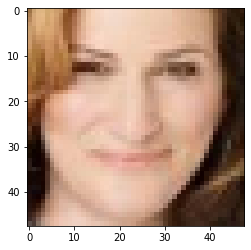

35
1


In [11]:
plt.imshow(images[87])
plt.show()
print(ages[87])
print(genders[87])

In [12]:
images_array = np.array(images)
ages_array = np.array(ages)
genders_array = np.array(genders)

In [13]:
np.save("/kaggle/working/images.npy",images_array)
np.save("/kaggle/working/ages.npy",ages_array)
np.save("/kaggle/working/genders.npy",genders_array)

### Finding Number of Elements in the Dataset

Gender distribution

In [14]:
values,counts = np.unique(genders_array, return_counts=True)
print("Number of males = ", counts[0])
print("Number of females = ", counts[1])

Number of males =  12391
Number of females =  11317


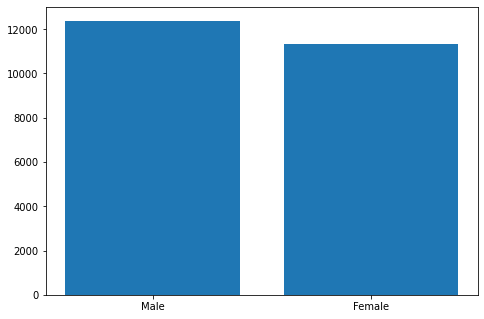

In [15]:
#Plotting the no:of male and female samples

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
gender = ["Male","Female"]
value = [counts[0],counts[1]]
ax.bar(gender,value)
plt.show()

Age distribution

In [16]:
#Plotting the samples age-wise

values,counts = np.unique(ages_array, return_counts=True)
print(counts)

[1123  482  289  273  196  131  139  263  166  156   65  130   81  157
  177  247  158  262   98  284  346  395  426  859  734 2197  615  918
  570  724  350  664  143  409  880  483  293  325  266  526  132  266
  157  100  440  153  170  153  148  381  138  232  241  353  268  236
   97  271   82  293  161  125  103   50  259   77   94  100   56  147
   33   98   63   32  148   58   28   69   23  133   22   40   18   24
  155   35   10   34   33   82    2   13    5    9   17    9   11    2
    1    5    5    1    3    4]


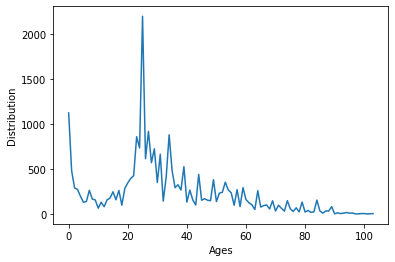

In [18]:
val = values.tolist()
cnt = counts.tolist()
plt.plot(counts)
plt.xlabel('Ages')
plt.ylabel('Distribution')
plt.show()

### Defining output labels

In [22]:
labels=[]
i=0
while i < len(ages):
    label = []
    label.append(ages[i])
    label.append(genders[i])
    labels.append(label)
    i = i + 1
    
labels_array = np.array(labels)
print(labels_array)

[[26  0]
 [22  1]
 [21  1]
 ...
 [ 2  0]
 [65  1]
 [66  0]]


In [25]:
# Getting another list of images from existing one for better learning
images_normalized = images_array/255
images_normalized.shape

(23708, 48, 48, 3)

## Splitting the Dataset into Train and Test Sets

In [27]:
X_train,X_test,y_train,y_test = train_test_split(images_normalized, labels_array, test_size = 0.25)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17781, 48, 48, 3)
(5927, 48, 48, 3)
(17781, 2)
(5927, 2)


In [35]:
print(y_train[0:5])
type(y_train)

[[49  0]
 [40  0]
 [16  0]
 [37  1]
 [28  1]]


numpy.ndarray

In [30]:
# Splitting 'y_train' and 'y_test' for better understanding
Y_train = [y_train[:,1], y_train[:,0]]
Y_test = [y_test[:,1], y_test[:,0]]
print(Y_train)
print(Y_test)

[array([0, 0, 0, ..., 1, 1, 1]), array([49, 40, 16, ..., 38, 32,  2])]
[array([0, 0, 0, ..., 0, 0, 1]), array([54,  1, 54, ..., 65, 40, 36])]


In [37]:
print(Y_train[0][0:5])
print(Y_train[1][0:5])
type(Y_train)

[0 0 0 1 1]
[49 40 16 37 28]


list

## Building the model

Using Convolutional Neural Networks(CNN).

As we increase the convolutional layers bias increases, but when we decrease it accuracy decreases(maxpool layers)

In [39]:
def convolution(input_tensor,filters):
    x = Conv2D(filters=filters, kernel_size=(3,3), padding="same", strides=(1,1), kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x) #determine which parameters to drop(avoids overfitting)
    x = Activation("relu")(x)
    return x

In [43]:
def model(input_shape):
    inputs = Input((input_shape))

    conv_1 = convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
    conv_2 = convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
    conv_3 = convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
    conv_4 = convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

    flatten = Flatten()(maxp_4)

    dense_1 = Dense(64,activation='relu')(flatten)
    dense_2 = Dense(64,activation='relu')(flatten)

    drop_1 = Dropout(0.2)(dense_1)
    drop_2 = Dropout(0.2)(dense_2)

    output_1 = Dense(1,activation='sigmoid',name='gender_output')(drop_1)
    output_2 = Dense(1,activation='relu',name='age_output')(drop_2)

    model = tf.keras.Model(inputs=[inputs], outputs=[output_1,output_2])
    model.compile(loss=["binary_crossentropy","mae"], optimizer="Adam", metrics=["accuracy"])

    return model

In [55]:
model_1 = model((48,48,3))

In [57]:
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 48, 48, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 48, 48, 32)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 48, 48, 32)   0           dropout_12[0][0]                 
____________________________________________________________________________________________

In [60]:
#initializing the model
file_s = "/kaggle/working/Age_Gender_Detection.h5"
checkpoint = ModelCheckpoint(file_s, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss', restore_best_weights=True)
callback_list = [checkpoint,early_stop]

## Training the Model

Running the Model 

*Caution: This will take time depending on the processor*


In [ ]:
History = model_1.fit(X_train, Y_train, batch_size=64, validation_data=(X_test,Y_test), epochs=250, callbacks=callback_list)

2023-01-09 12:41:45.834475: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 491609088 exceeds 10% of free system memory.
2023-01-09 12:41:46.481709: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 491609088 exceeds 10% of free system memory.
2023-01-09 12:41:46.946201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250


2023-01-09 12:41:50.528897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


278/278 [==============================] - 19s 19ms/step - loss: 17.1652 - gender_output_loss: 0.6931 - age_output_loss: 16.2958 - gender_output_accuracy: 0.5234 - age_output_accuracy: 0.0466 - val_loss: 16.3906 - val_gender_output_loss: 0.6862 - val_age_output_loss: 15.5515 - val_gender_output_accuracy: 0.5183 - val_age_output_accuracy: 0.0489

Epoch 00001: val_loss improved from inf to 16.39058, saving model to /kaggle/working/Age_Gender_Detection.h5
Epoch 2/250
278/278 [==============================] - 4s 13ms/step - loss: 14.4400 - gender_output_loss: 0.6618 - age_output_loss: 13.6123 - gender_output_accuracy: 0.5859 - age_output_accuracy: 0.0467 - val_loss: 13.0812 - val_gender_output_loss: 0.6312 - val_age_output_loss: 12.2635 - val_gender_output_accuracy: 0.7123 - val_age_output_accuracy: 0.0479

Epoch 00002: val_loss improved from 16.39058 to 13.08118, saving model to /kaggle/working/Age_Gender_Detection.h5
Epoch 3/250
278/278 [==============================] - 4s 13ms/step - 

In [62]:
pred = model_1.predict(X_test)
print(pred[1])

[[41.99613  ]
 [ 1.8623172]
 [54.49663  ]
 ...
 [64.32922  ]
 [43.839474 ]
 [37.131325 ]]


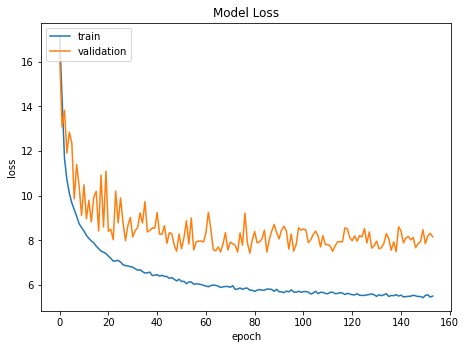

In [63]:
#  Plotting Loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","validation"],loc="upper left")
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

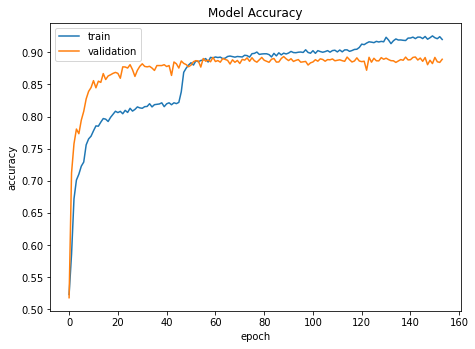

In [64]:
# Plotting Gender Accuracy
plt.plot(History.history["gender_output_accuracy"])
plt.plot(History.history["val_gender_output_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","validation"],loc="upper left")
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

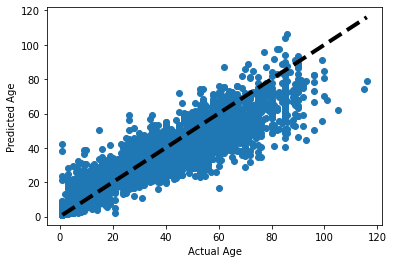

In [84]:
# Plottiong Age Accuray
fig,ax = plt.subplots()
ax.scatter(Y_test[1],pred[1])
ax.plot([Y_test[1].min(),Y_test[1].max()], [Y_test[1].min(),Y_test[1].max()], "k--", linewidth=4)
ax.set_xlabel("Actual Age")
ax.set_ylabel("Predicted Age")
plt.show()

## Making Report of the Model

In [85]:
i=0
prediction = []
while (i < len(pred[0])):
    prediction.append(np.round(pred[0][i]))
    i = i + 1

In [88]:
report = classification_report(Y_test[0], prediction)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      3072
           1       0.90      0.86      0.88      2855

    accuracy                           0.89      5927
   macro avg       0.89      0.89      0.89      5927
weighted avg       0.89      0.89      0.89      5927



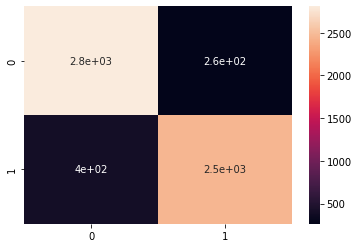

In [90]:
results = confusion_matrix(Y_test[0], prediction)
sns.heatmap(results, annot=True) #heatmap of the model(gender output)
plt.show()

## Test Cases

In [113]:
def test_image(index,images_array,images_norm,model):
    plt.imshow(images_array[index])
    image_test = np.array([images_norm[index]])
#     print(image_test.shape)
    predicted = model.predict(image_test)
    genders_list = ["Male","Female"]
    age = int(np.round(predicted[1][0]))
    gender = int(np.round(predicted[0][0]))
    print("Predicted age is " + str(age))
    print("Predicted gender is " + genders_list[gender])

Predicted age is 20
Predicted gender is Female


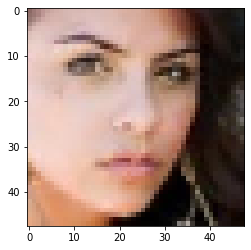

In [114]:
#test_1
test_image(4,images_array,images_normalized,model_1)

Predicted age is 42
Predicted gender is Male


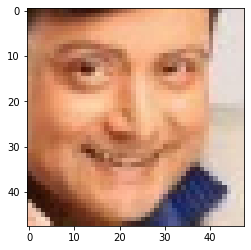

In [115]:
#test_2
test_image(23,images_array,images_normalized,model_1)

Predicted age is 62
Predicted gender is Female


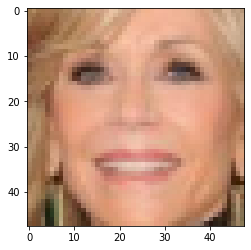

In [116]:
#test_3
test_image(168,images_array,images_normalized,model_1)

Predicted age is 66
Predicted gender is Male


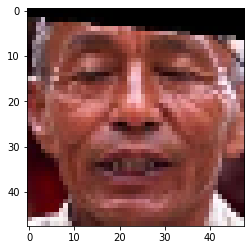

In [117]:
#test_4
test_image(888,images_array,images_normalized,model_1)

Predicted age is 26
Predicted gender is Male


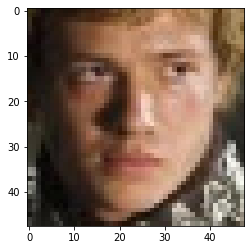

In [118]:
#test_5
test_image(1288,images_array,images_normalized,model_1)